In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd

current_dir = os.getcwd()
parent_dir  = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.helpers import (
    keep_only_load_30min,
    halfhour_to_daily_mwh,
    load_temperature
)
from src.utils.plot import (
    plot_temp_vs_consumption, 
    add_piecewise_fit,
    plot_full_year_30min,
    plot_full_year_daily,
    plot_avg_intraday_profiles,
    plot_avg_weekly_profiles,
    plot_avg_intraweek_profiles,
    plot_temperature
)

## RTE Load Data Vizualisation and Analysis

#### Load one RTE file: year 2024

In [2]:
df = pd.read_csv("../data/load_rte/2024.csv")
df.head()

,zone,data_status,date,hour,load_mw,day_minus_1_forecast_mw,day_forecast_mw,oil_total_mw,coal_mw,gas_total_mw,...,hydraulique_fil_de_l_eau_eclusee,hydro_reservoirs_mw,pumped_storage_turbining_mw,bioenergy_waste_mw,bioenergy_biomass_mw,bioenergy_biogas_mw,battery_charge_mw,battery_discharge_mw,onshore_wind_mw,offshore_wind_mw
0,France,Données consolidées,2024-01-01,00:00,55239.0,55000.0,54200.0,96.0,18.0,1975.0,...,5001.0,1553.0,117.0,510.0,354.0,347.0,0.0,0.0,14976.0,581.0
1,France,Données consolidées,2024-01-01,00:15,NaN,54300.0,53400.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,France,Données consolidées,2024-01-01,00:30,54560.0,53600.0,52600.0,96.0,17.0,1919.0,...,4937.0,1569.0,6.0,510.0,355.0,347.0,0.0,0.0,14880.0,579.0
3,France,Données consolidées,2024-01-01,00:45,NaN,53200.0,51950.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,France,Données consolidées,2024-01-01,01:00,52689.0,52800.0,51300.0,95.0,17.0,2000.0,...,4910.0,1179.0,6.0,513.0,359.0,344.0,0.0,0.0,14773.0,582.0


#### Display columns names

In [3]:
df.columns

Index(['zone', 'data_status', 'date', 'hour', 'load_mw',
       'day_minus_1_forecast_mw', 'day_forecast_mw', 'oil_total_mw', 'coal_mw',
       'gas_total_mw', 'nuclear_mw', 'wind_total_mw', 'solar_mw',
       'hydro_total_mw', 'pumped_storage_pumping_mw', 'bioenergy_total_mw',
       'physical_exchanges_mw', 'co2_intensity_g_per_kwh',
       'commercial_exchange_gb_mw', 'commercial_exchange_es_mw',
       'commercial_exchange_it_mw', 'commercial_exchange_ch_mw',
       'commercial_exchange_de_be_mw', 'oil_ocgt_mw', 'oil_cogen_mw',
       'oil_other_mw', 'gas_ocgt_mw', 'gas_cogen_mw', 'gas_ccgt_mw',
       'gas_other_mw', 'hydraulique_fil_de_l_eau_eclusee',
       'hydro_reservoirs_mw', 'pumped_storage_turbining_mw',
       'bioenergy_waste_mw', 'bioenergy_biomass_mw', 'bioenergy_biogas_mw',
       'battery_charge_mw', 'battery_discharge_mw', 'onshore_wind_mw',
       'offshore_wind_mw'],
      dtype='object')

### Columns names explanation

RTE Columns Glossary (MW unless noted)

- zone — Geographic perimeter of the data (e.g., France).
- data_status — Data maturity (e.g., real-time, consolidated, definitive).
- date, hour — Local timestamp (Europe/Paris).
- load_mw — Total national electricity demand (average power over the 30-min slot).

Short-term demand forecasts
- day_minus_1_forecast_mw — Day-ahead (J-1) demand forecast calculated by RTE.
- day_forecast_mw — Same-day (intraday, J) demand forecast.

Generation by fuel (aggregates)
- oil_total_mw, coal_mw, gas_total_mw, nuclear_mw, wind_total_mw, solar_mw, hydro_total_mw, bioenergy_total_mw — Production by fuel family.

Fuel sub-breakdowns
- oil_ocgt_mw, oil_cogen_mw, oil_other_mw
- gas_ocgt_mw, gas_cogen_mw, gas_ccgt_mw, gas_other_mw

Hydro details
- hydraulique_fil_de_l_eau_eclusee — Run-of-river & sluiced hydro generation.
- hydro_reservoirs_mw — Reservoir (storage) hydro generation.
- pumped_storage_turbining_mw — Pumped-storage in generation mode.
- pumped_storage_pumping_mw — Pumped-storage consumption (pumping load).

Wind details
- onshore_wind_mw, offshore_wind_mw — Wind generation split by location.

Bioenergy details
- bioenergy_waste_mw, bioenergy_biomass_mw, bioenergy_biogas_mw — Bioenergy by feedstock.

Storage (batteries)
- battery_discharge_mw — Battery generation (discharging).
- battery_charge_mw — Battery consumption (charging).

Cross-border exchanges
(Note: Sign convention may vary; commonly positive = import into France.)
- physical_exchanges_mw — Net physical flow across all borders.
- commercial_exchange_gb_mw / es_mw / it_mw / ch_mw / de_be_mw — Net commercial exchanges with UK, Spain, Italy, Switzerland, Germany-Belgium.

Carbon
- co2_intensity_g_per_kwh — Estimated grid CO₂ intensity (grams CO₂ per kWh).

Notes
 - Half-hour rows are average power over the interval; daily energy (MWh) = Σ(MW × 0.5 h).
 - Forecast columns refer to demand, not generation.
 - Verify exchange sign in your specific file’s metadata and keep it consistent in analysis.

In [4]:
load_30min = keep_only_load_30min(df)
daily_mwh = halfhour_to_daily_mwh(load_30min, col="load_mw_30min")

#### 1) Full-year lines

<Axes: title={'center': 'France load (30-min) — full year'}, xlabel='Date', ylabel='MW'>

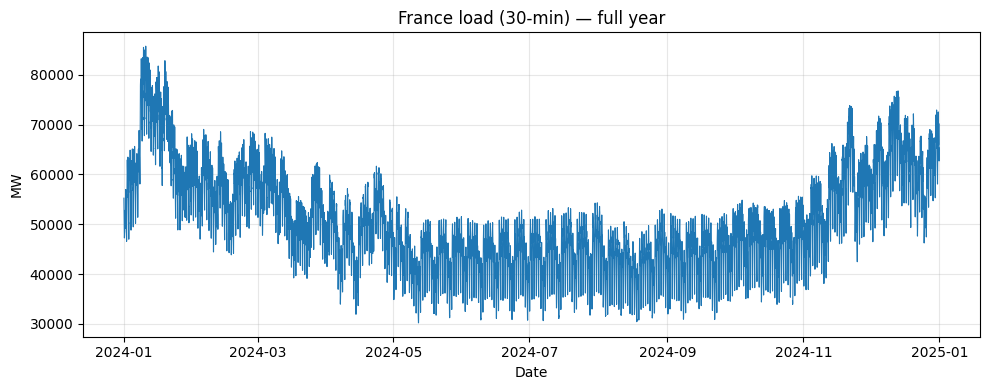

In [5]:
plot_full_year_30min(load_30min, col="load_mw_30min",
                     title="France load (30-min) — full year")

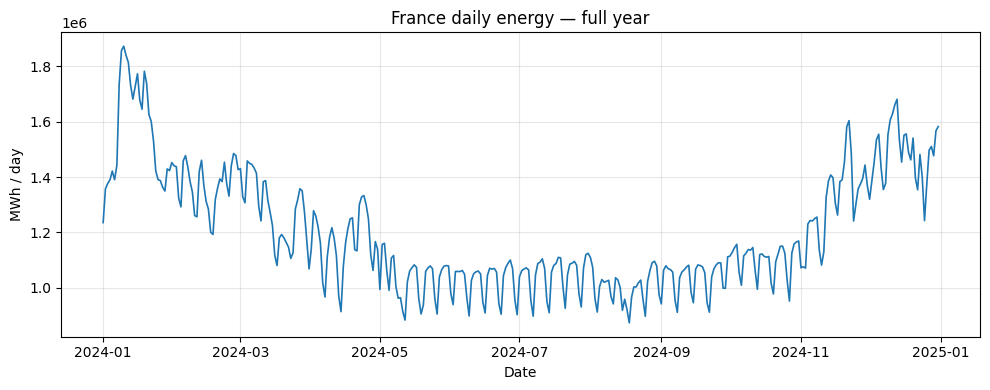

In [6]:
plot_full_year_daily(daily_mwh,
                     title="France daily energy — full year")

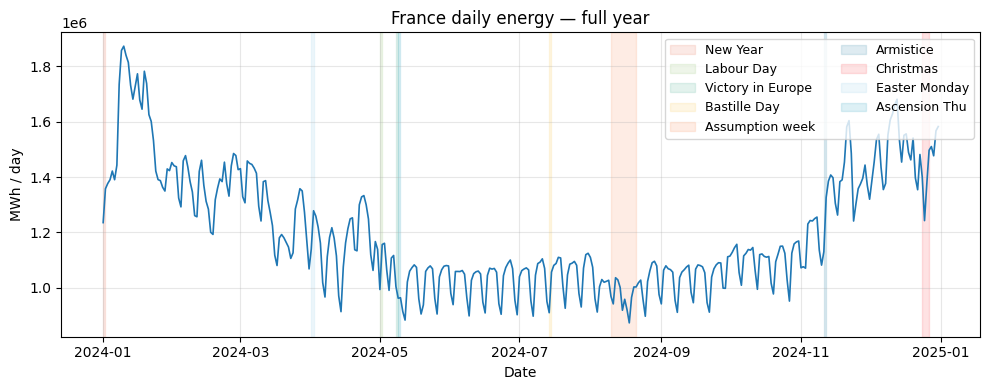

In [7]:
plot_full_year_daily(daily_mwh,
                     title="France daily energy — full year", 
                     add_events=True)

### 2) Average intraday profiles (30-min curves): all / winter / summer

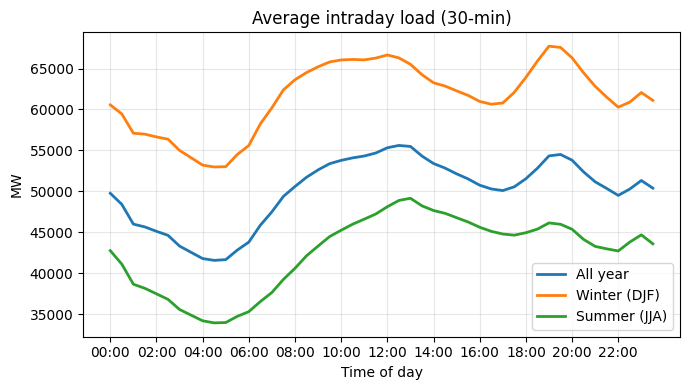

In [8]:
plot_avg_intraday_profiles(load_30min, col="load_mw_30min",
                           title_prefix="Average intraday load (30-min)")

### 3) Average intraday/intraweek profiles heatmap (30-min)

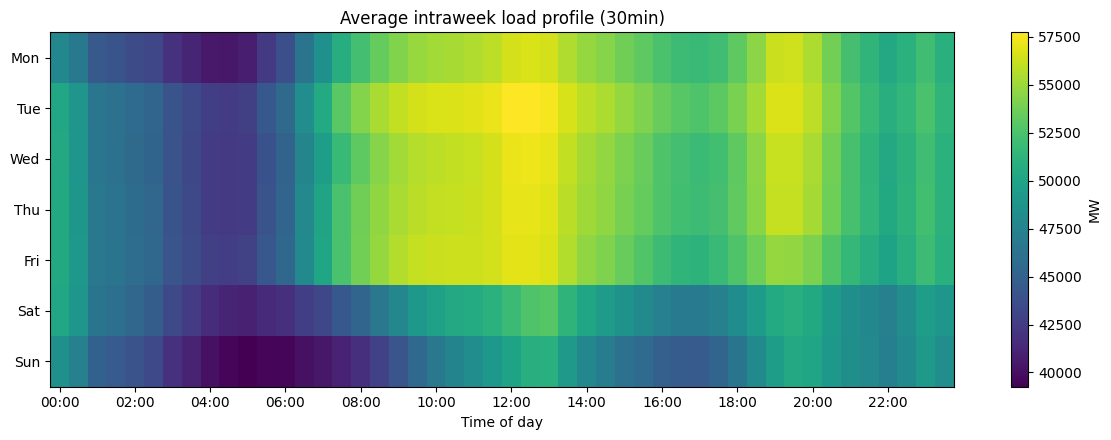

In [9]:
plot_avg_intraweek_profiles(load_30min, col="load_mw_30min",
                            title_prefix="Average intraweek load profile (30min)")

### 4) Average weekday energy: all / winter / summer

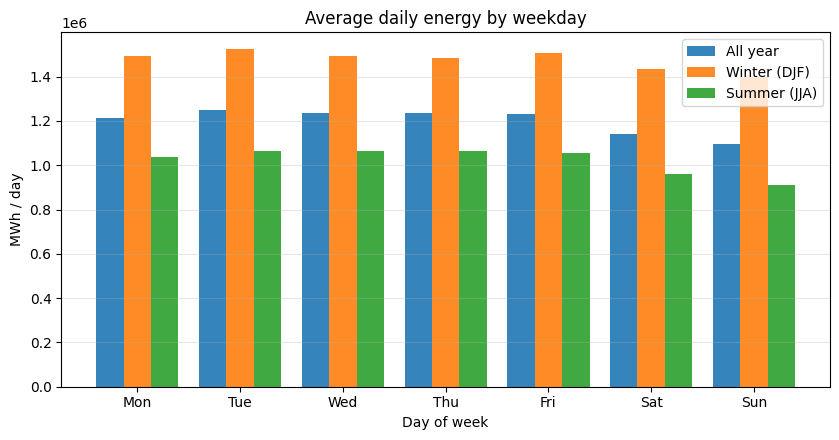

In [10]:
plot_avg_weekly_profiles(load_30min, col="load_mw_30min",
                         title_prefix="Average daily energy by weekday")

### 5) Temperature influence

In [11]:
temp = load_temperature("../data/temp/")

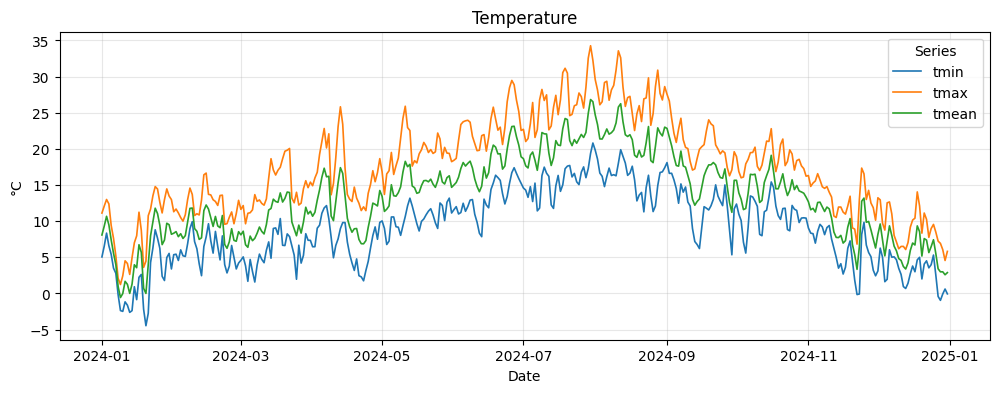

In [12]:
plot_temperature(temp, date_start="2024-01-01", date_end="2024-12-31")

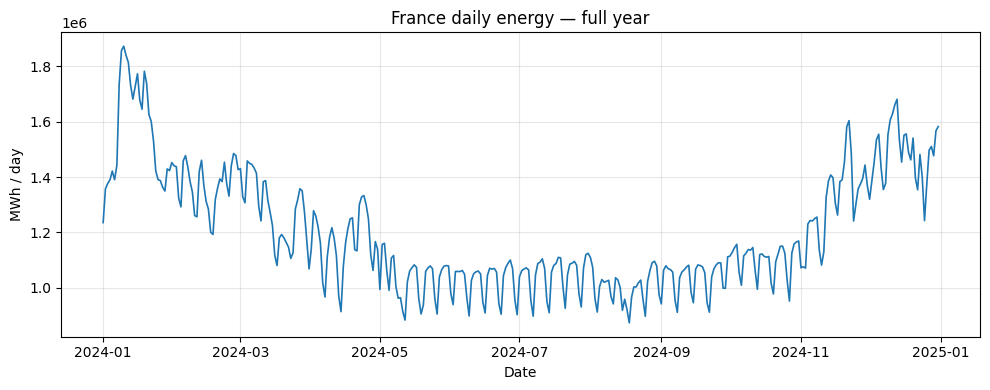

In [13]:
plot_full_year_daily(daily_mwh, title="France daily energy — full year")

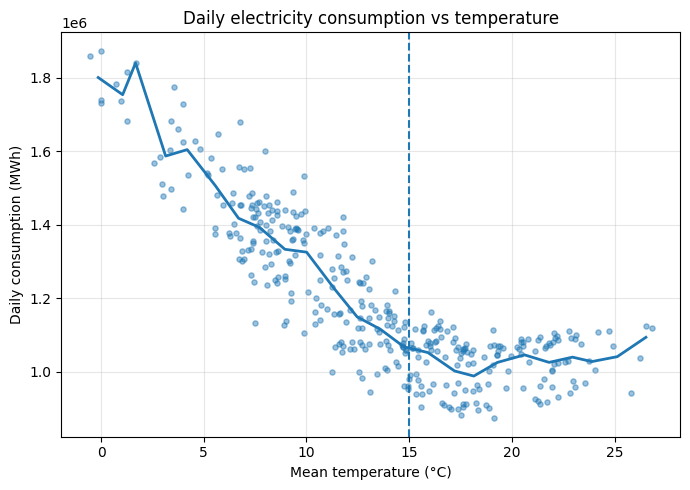

In [14]:
daily_mwh_ = daily_mwh.copy()
daily_mwh_.index.name = "date"
df = pd.merge(daily_mwh_, temp, how='left', on='date')
ax = plot_temp_vs_consumption(df, temp_col="tmean") 

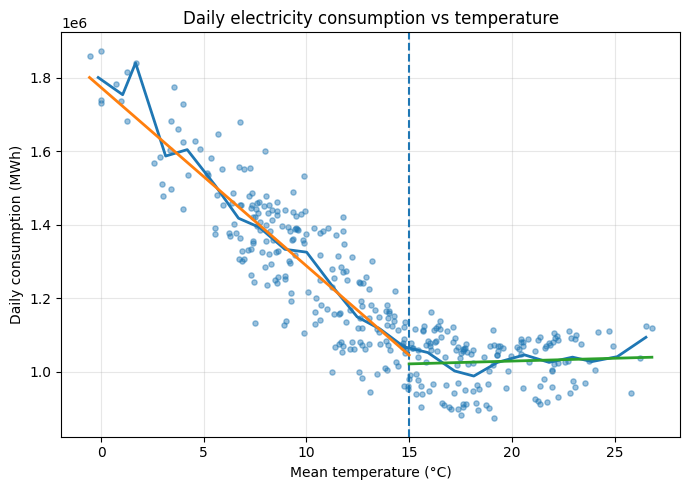

In [15]:
d = df[["tmean", "load_mwh"]].dropna()
ax = plot_temp_vs_consumption(df, temp_col="tmean")
add_piecewise_fit(ax, d["tmean"], d.iloc[:,1], pivot_c=15.0)
